<a href="https://github.com/groda/big_data"><div><img src="https://github.com/groda/big_data/blob/master/logo_bdb.png?raw=true" align=right width="90" alt="Logo Big Data for Beginners"></div></a>
# N-grams with PySpark


In this notebook we are going to extract _n-grams_ from a text file using PySpark.

N-grams in Natural Language Processing refer to sequences of tokens (or words) used to calculate the probability of a word given its preceding context. In a _bigram_ model, the prediction for the next word relies on the single preceding word, while in a _trigram_ model, it considers the two preceding words, and so forth.

We will utilize the PySpark distribution provided by `pip` with its integrated Spark engine running as a single Java virtual machine in _pseudo-distributed mode_.

More questions on PySpark are answered in the tutorial [PySpark on Google Colab](https://github.com/groda/big_data/blob/master/PySpark_On_Google_Colab.ipynb).

##  <font color='crimson'>༺✿༻ 𝒲𝑜𝓇𝒹𝓈 𝓌𝒾𝓉𝒽 𝒶 𝓅𝒶𝓈𝓉 ༺✿༻</font>


### Is a “gram” an English word?
You have certainly seen the suffix “gram” in other words such as “telegram”, “diagram”, “electrocardiogram”. Well, this is no coincidence as they all have the same origin in the Ancient Greek γράμμα, which meant “written character, letter, that which is drawn.” And by the way, γράμμα is the noun from the verb γράφειν (graphein) that means “to write”, “to draw”. So words such as program, diagram, graph, photograph, biography, they all share the same root.


### And By The Way: Etymology of Curiosity

The word *curiosity* [stems from the Latin **cura**](https://www.etymonline.com/word/curiosity), meaning “care.” Over time, it evolved to signify a strong desire to know or learn — something that compels us to explore the unknown with care and attention.

Let’s follow the path of words as they carry memory, change, and wonder through time. 🌿

### <font color='crimson'>༺❀༻</font>




# Install PySpark

On Google Colab it is not necessary to install PySpark because it is included by default, as one can verify with `pip show pyspark`.

In [1]:
# IN_COLAB is true if running on Google Colab
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  print("Running on Google Colab")
  !pip show pyspark
else:
  print("Not running on Google Colab. Importing PySpark")
  import pyspark

Running on Google Colab
Name: pyspark
Version: 3.5.1
Summary: Apache Spark Python API
Home-page: https://github.com/apache/spark/tree/master/python
Author: Spark Developers
Author-email: dev@spark.apache.org
License: http://www.apache.org/licenses/LICENSE-2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: py4j
Required-by: dataproc-spark-connect


# Download a text file

In [2]:
FILENAME = 'don_quixote.txt'
!wget --no-clobber https://www.gutenberg.org/cache/epub/996/pg996.txt -O {FILENAME}

--2025-07-27 21:10:08--  https://www.gutenberg.org/cache/epub/996/pg996.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2391721 (2.3M) [text/plain]
Saving to: ‘don_quixote.txt’

don_quixote.txt     100%[===================>]   2.28M  3.25MB/s    in 0.7s    

2025-07-27 21:10:09 (3.25 MB/s) - ‘don_quixote.txt’ saved [2391721/2391721]



The file has size 2.3 megabytes.

In [3]:
!ls -lh {FILENAME}

-rw-r--r-- 1 root root 2.3M Jul  1 11:54 don_quixote.txt


# Spark Web UI

The Spark Web UI

> “*provides a suite of web user interfaces (UIs) that you can use to monitor the status and resource consumption of your Spark cluster.*” (https://spark.apache.org/docs/3.5.0/web-ui.html)

See more in the official [Spark Documentation](https://spark.apache.org/docs/3.5.0/web-ui.html).


## Set `SPARK_HOME`

In [4]:
import subprocess
import os
# Run the script and capture its output
result = subprocess.run(["find_spark_home.py"], capture_output=True, text=True)

# Print or use the captured output
print("Output of find_spark_home.py:", result.stdout)

# set SPARK_HOME environment variable
os.environ['SPARK_HOME'] = result.stdout.strip()

Output of find_spark_home.py: /usr/local/lib/python3.11/dist-packages/pyspark



## Import `output` library if in Colab

The Web UI can be viewed in a separate windows or tab thanks to Colab's `output` library.


In [5]:
if IN_COLAB:
 from google.colab import output

### Spark UI

In [6]:
if IN_COLAB:
  output.serve_kernel_port_as_window(4040, path='/jobs/index.html')

Try `serve_kernel_port_as_iframe` instead. 


<IPython.core.display.Javascript object>

If you click on the link above you won't see anything at this point. The Web UI will get started as soon as you create a context.

# Create a Spark context

In [7]:
from pyspark import SparkContext

sc = SparkContext(
    appName = "Ngrams with PySpark " + FILENAME
)

## View Spark context

In [8]:
sc

<SparkContext master=local[*] appName=Ngrams with PySpark don_quixote.txt>

The Spark Web UI should now be active.

In [9]:
if IN_COLAB:
  output.serve_kernel_port_as_window(4040, path='/jobs/index.html')

Try `serve_kernel_port_as_iframe` instead. 


<IPython.core.display.Javascript object>

When your Spark job runs you see something like this:

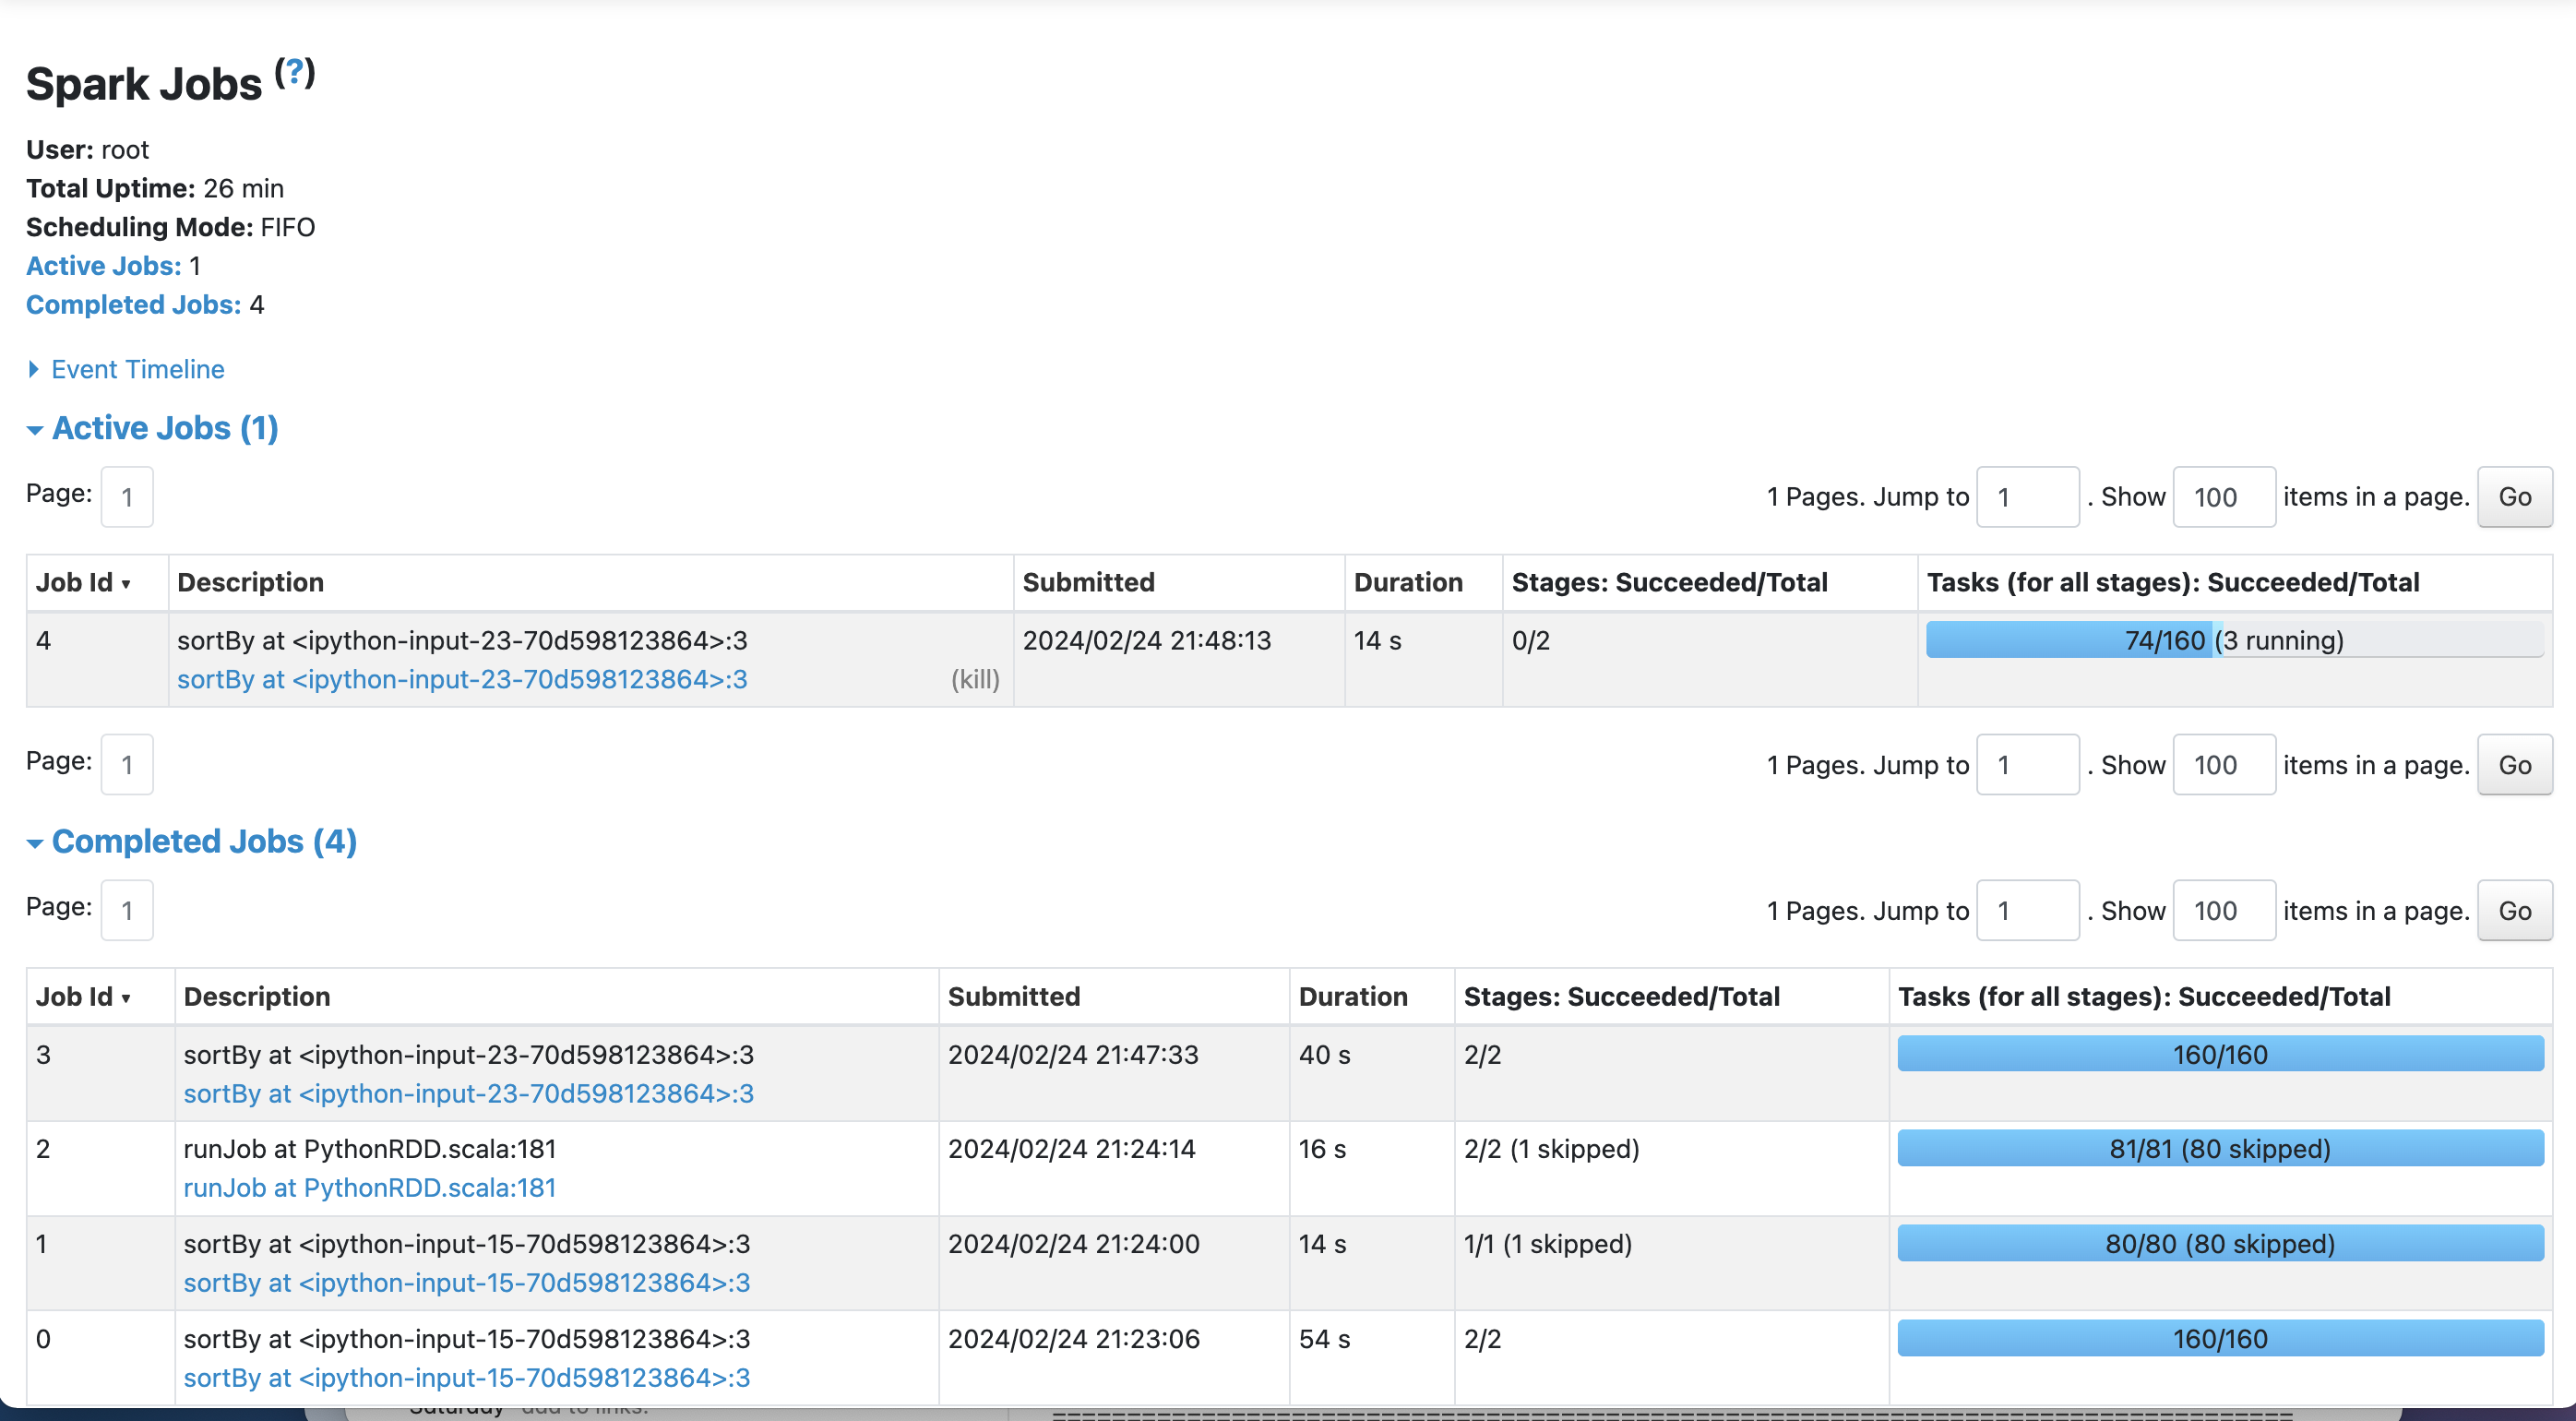

# Create a Resilient Distributed Dataset from file

We are going to use the function [`wholeTextFiles`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.SparkContext.wholeTextFiles.html) to read the whole file as a single record into a [Resilient Distributed Dataset (RDD)](https://spark.apache.org/docs/latest/rdd-programming-guide.html#resilient-distributed-datasets-rdds).

Not that with `wholeTextFiles`
> _Each file is read as a single record and returned in a key-value pair, where the key is the path of each file, the value is the content of each file._

In [10]:
textFile = sc.wholeTextFiles(FILENAME)

Verify that `textFile` is a 1-line RDD and print out the number of records and partitions.

In [11]:
print(f'textFile is of type: {type(textFile)}, it contains {textFile.count()} lines and is split into {textFile.getNumPartitions()} partitions')

textFile is of type: <class 'pyspark.rdd.RDD'>, it contains 1 lines and is split into 1 partitions


The reason why we want the wole document in one line is to be able to capture n-grams across multiple lines. So for instance if we have a file

```
This is line one
and this is line two.
```

we want to be able to capture the bigram `one and` or the trigrams `line one and` and `one and this`, etc. that are spread across multiple lines in the original file.

# Generate trigrams

Change `n` to generate n-grams. Here will use `n=3` to generate trigrams.

In [12]:
from operator import add
n = 3
ngrams = textFile.map(lambda x: x[1]) \
                 .map(lambda text: text.replace('\n', ' ').replace('\r', ' ')) \
                 .flatMap(lambda x: [x.split()]) \
                 .flatMap(lambda x: [tuple(y) for y in zip(*[x[i:] for i in range(n)])]) \
                 .map(lambda x: (x, 1)) \
                 .reduceByKey(add) \
                 .sortBy(lambda x: x[1], ascending=False)

The next command is the one that triggers an actual computation, therefore it might take a couple of seconds to complete.

In [13]:
print(f'The input file contains {ngrams.count()} {n}-grams')

The input file contains 345317 3-grams


In [14]:
print(f'ngrams is a RDD: {type(ngrams)}')
type(ngrams)

ngrams is a RDD: <class 'pyspark.rdd.PipelinedRDD'>


pyspark.rdd.PipelinedRDD

Let us look at the top $10$ trigrams (note that we sorted by frequency in the above code by using `.sortBy(lambda x: x[1], ascending=False)`).

In [15]:
for (ngram, count) in ngrams.take(10):
    print("%s: %i" % (ngram, count))

('said', 'Don', 'Quixote,'): 244
('one', 'of', 'the'): 167
('said', 'Don', 'Quixote;'): 120
('Don', 'Quixote', 'of'): 107
('Quixote', 'of', 'La'): 103
('Sancho,”', 'said', 'Don'): 99
('as', 'well', 'as'): 94
('out', 'of', 'the'): 92
('that', 'I', 'am'): 88
('that', 'he', 'was'): 87


## Explanation of the code used for generating n-grams

```
ngrams = textFile.map(lambda x: x[1]) \
                 .map(lambda text: text.replace('\n', ' ').replace('\r', ' ')) \
                 .flatMap(lambda x: [x.split()]) \
                 .flatMap(lambda x: [tuple(y) for y in zip(*[x[i:] for i in range(n)])]) \
                 .map(lambda x: (x, 1)) \
                 .reduceByKey(add) \
                 .sortBy(lambda x: x[1], ascending=False)
```

First of all, a small remark on the usage of the backslash (`\`) used to break long lines to represent line continuation: if all of a sudden you get some strange error message, make sure that the backslash is the last character in the line (there might be some white characters after `\` that need to be deleted).

- `map(lambda x: x[1])` The function [`wholeTextFiles`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.SparkContext.wholeTextFiles.html) reads each file as a single record and returns in a key-value pair, where the key is the path of each file `(path/of/file, content)` so we need to extract the second component to get the content of the file.
- `map(lambda text: text.replace('\n', ' ').replace('\r', ' '))` removes all newline characters.
- `flatMap(lambda x: [x.split()])` splits text at whitespaces, a very basic tokenization.
- `flatMap(lambda x: [tuple(y) for y in zip(*[x[i:] for i in range(n)])])` This is the core of the n-gram generation:
  - `[x[i:] for i in range(n)]` creates a list of shifted versions of the input list x. For example, if x is `['a', 'b', 'c', 'd']` and `n` is 3 (for trigrams):
   - `i=0`: `x[0:]` is `['a', 'b', 'c', 'd']`
   - `i=1`: `x[1:]` is `['b', 'c', 'd']`
   - `i=2`: `x[2:]` is `['c', 'd']`
   
   The list becomes `[['a', 'b', 'c', 'd'], ['b', 'c', 'd'], ['c', 'd']]`

   `zip` then takes these lists and combines elements at the same index into tuples. Using the example above `zip(['a', 'b', 'c', 'd'], ['b', 'c', 'd'], ['c', 'd'])` would produce `[('a', 'b', 'c'), ('b', 'c', 'd')]`
   Essentially, it aligns the words to create tuples of n consecutive words.
- `map(lambda x: (x, 1))` and `reduceByKey(add)` are the classical map-and-reduce methods for counting frequencies
- finally, `sortBy` sorts the results by descending frequency


## Code improvements

### 1. Normalize text

There are some improvements that can immediately be done to the code. Firstly, we can improve `.flatMap(lambda x: [x.split()])`. This is the function used to split each line of the input text into _tokens_ and as it is it is a very rudimentary method.

The transformation

```
.map(lambda text: re.sub(r'\s+', ' ', text).lower().strip())
```

collates multiple whitespaces into a single one (`re.sub(r'\s+', ' ', text)`), converts the entire text to lowercase (`lower()`), and removes any leading or trailing whitespace (`strip()`).

The whitespaces elimination is not necessary in our pipeline since at the next step we're applying `flatMap(lambda x: [x.split()])` which treats any sequence of whitespace as a delimiter but it is a common practice for text normalization to have consistent spacing.

Mapping everything to lower case so that “the” and “The” are the same token is also called _case folding_.


In [16]:
import re
from operator import add
n = 3
ngrams = textFile.map(lambda x: x[1]) \
                 .map(lambda text: text.replace('\n', ' ').replace('\r', ' ')) \
                 .map(lambda text: re.sub(r'\s+', ' ', text).lower().strip()) \
                 .flatMap(lambda x: [x.split()]) \
                 .flatMap(lambda x: [tuple(y) for y in zip(*[x[i:] for i in range(n)])]) \
                 .map(lambda x: (x, 1)) \
                 .reduceByKey(add) \
                 .sortBy(lambda x: x[1], ascending=False)

### 2. Sentence segmentation

Let us consider a file containing the text

“The first sentence ends here. The second sentence ends here.”


In [17]:
%%bash
cat >input_file.txt <<🐸
The first sentence ends here. The second sentence ends here.
🐸

Ket us load the file `input_file.txt` into `inputFile`.

In [18]:
inputFile = sc.wholeTextFiles('input_file.txt')

After normalization we get:

In [19]:
n = 3
inputFile.map(lambda x: x[1]) \
        .map(lambda text: text.replace('\n', ' ').replace('\r', ' ')) \
        .map(lambda text: re.sub(r'\s+', ' ', text).lower().strip()) \
        .collect()

['the first sentence ends here. the second sentence ends here.']

We split the text into tokens

In [20]:
inputFile.map(lambda x: x[1]) \
        .map(lambda text: text.replace('\n', ' ').replace('\r', ' ')) \
        .map(lambda text: re.sub(r'\s+', ' ', text).lower().strip()) \
        .flatMap(lambda x: [x.split()]) \
        .collect()

[['the',
  'first',
  'sentence',
  'ends',
  'here.',
  'the',
  'second',
  'sentence',
  'ends',
  'here.']]

and extract all trigrams

In [21]:
inputFile.map(lambda x: x[1]) \
        .map(lambda text: text.replace('\n', ' ').replace('\r', ' ')) \
        .map(lambda text: re.sub(r'\s+', ' ', text).lower().strip()) \
        .flatMap(lambda x: [x.split()]) \
        .flatMap(lambda x: [tuple(y) for y in zip(*[x[i:] for i in range(n)])]) \
        .collect()

[('the', 'first', 'sentence'),
 ('first', 'sentence', 'ends'),
 ('sentence', 'ends', 'here.'),
 ('ends', 'here.', 'the'),
 ('here.', 'the', 'second'),
 ('the', 'second', 'sentence'),
 ('second', 'sentence', 'ends'),
 ('sentence', 'ends', 'here.')]

But we actually do not want to extract the trigrams “ends here the” and “here the second” that goes across two sentences. We just want trigrams that appear inside a sentence.

In order to identify sentences in a text we need to mark sentence boundaries such as periods, question marks, exclamation points. This process is also called _sentence segmentation_.

We first split the text using a sentence delimiters regular expression.

In [22]:
# Sentence delimiter regex: one or more periods, question marks, or exclamation points
# followed by whitespace or the end of the string.
sentence_delimiters_regex = r'[.!?]+(?=\s+|$)'

inputFile.map(lambda x: x[1]) \
        .map(lambda text: text.replace('\n', ' ').replace('\r', ' ')) \
        .map(lambda text: re.sub(r'\s+', ' ', text).lower().strip()) \
        .flatMap(lambda text: re.split(sentence_delimiters_regex, text)) \
        .collect()

['the first sentence ends here', ' the second sentence ends here', '']

Then apply the `split()` to each sentence

In [23]:
inputFile.map(lambda x: x[1]) \
         .map(lambda text: text.replace('\n', ' ').replace('\r', ' ')) \
         .map(lambda text: re.sub(r'\s+', ' ', text).lower().strip()) \
         .flatMap(lambda text: re.split(sentence_delimiters_regex, text)) \
         .map(lambda sentence: [word for word in sentence.split()]) \
         .collect()

[['the', 'first', 'sentence', 'ends', 'here'],
 ['the', 'second', 'sentence', 'ends', 'here'],
 []]

Filter out empty sentences

In [24]:
inputFile.map(lambda x: x[1]) \
         .map(lambda text: text.replace('\n', ' ').replace('\r', ' ')) \
         .map(lambda text: re.sub(r'\s+', ' ', text).lower().strip()) \
         .flatMap(lambda text: re.split(sentence_delimiters_regex, text)) \
         .map(lambda sentence: [word for word in sentence.split()]) \
         .filter(lambda sentence_words: sentence_words) \
         .collect()

[['the', 'first', 'sentence', 'ends', 'here'],
 ['the', 'second', 'sentence', 'ends', 'here']]

And finally introduce sentence delimiters ⮕ and ⬅.

Note that the `(n-1)` padding is a standard technique in n-gram language modeling to properly handle sentence boundaries and ensure that n-grams at the beginning of sentences are correctly represented and counted.

In [25]:
inputFile.map(lambda x: x[1]) \
         .map(lambda text: text.replace('\n', ' ').replace('\r', ' ')) \
         .map(lambda text: re.sub(r'\s+', ' ', text).lower().strip()) \
         .flatMap(lambda text: re.split(sentence_delimiters_regex, text)) \
         .map(lambda sentence: [word for word in sentence.split()]) \
         .filter(lambda sentence_words: sentence_words) \
          .map(lambda sentence_words: ['⮕'] * (n - 1) + sentence_words + ['⬅']) \
         .flatMap(lambda x: [tuple(y) for y in zip(*[x[i:] for i in range(n)])]) \
         .map(lambda x: (x, 1)) \
         .reduceByKey(add) \
         .collect()

[(('⮕', '⮕', 'the'), 2),
 (('⮕', 'the', 'first'), 1),
 (('the', 'first', 'sentence'), 1),
 (('first', 'sentence', 'ends'), 1),
 (('sentence', 'ends', 'here'), 2),
 (('ends', 'here', '⬅'), 2),
 (('⮕', 'the', 'second'), 1),
 (('the', 'second', 'sentence'), 1),
 (('second', 'sentence', 'ends'), 1)]

For more details on _text normalization_ we refer to Chapter 2 of the book [_Speech and Language Processing_](https://web.stanford.edu/~jurafsky/slp3/) by Dan Jurafsky and James H. Martin.

# Language Model

Now that we have improved out n-gram extraction, let us pack these n-grams into a _model_ and use it to generate random sentences.



Process the original book again using the new normalization and sentence segmentation.

In [26]:
ngrams = textFile.map(lambda x: x[1]) \
                 .map(lambda text: text.replace('\n', ' ').replace('\r', ' ')) \
                 .map(lambda text: re.sub(r'\s+', ' ', text).lower().strip()) \
                 .flatMap(lambda text: re.split(sentence_delimiters_regex, text)) \
                 .map(lambda sentence: [word for word in sentence.split()]) \
                 .filter(lambda sentence_words: sentence_words) \
                 .map(lambda sentence_words: ['⮕'] * (n - 1) + sentence_words + ['⬅']) \
                 .flatMap(lambda x: [tuple(y) for y in zip(*[x[i:] for i in range(n)])]) \
                 .map(lambda x: (x, 1)) \
                 .reduceByKey(add) \
                 .collect()

Generate the the n-gram language model `language_model`.

In [27]:
from collections import defaultdict
import random

# Build the language model from the ngrams RDD
# The model will be a dictionary where keys are contexts (tuples of n-1 words)
# and values are dictionaries mapping the next word to its probability.
language_model = defaultdict(dict)
context_counts = defaultdict(int)

# First, calculate the counts of each context (the first n-1 words)
for (ngram, count) in ngrams: # Collect the ngrams RDD to process it locally
    context = tuple(ngram[:-1])
    next_word = ngram[-1]
    context_counts[context] += count

# Then, calculate the probabilities of the next word given the context
for (ngram, count) in ngrams:
    context = tuple(ngram[:-1])
    next_word = ngram[-1]
    if context in context_counts and context_counts[context] > 0:
        language_model[context][next_word] = count / context_counts[context]

The model is saved as a Python dictionary.

In [28]:
print(f'The n-gram model language_model is of type: {type(language_model)}')
print(f'and it contains {len(language_model)} entries')

The n-gram model language_model is of type: <class 'collections.defaultdict'>
and it contains 177717 entries


## Size of the model

Let us compute the size of our language model and compare it to the size of the original file.

In [29]:
import sys
import os

# Get size of FILENAME
file_size_bytes = os.path.getsize(FILENAME)
file_size_mb = file_size_bytes / (1024 * 1024)
print(f"Size of the file {FILENAME}: {file_size_mb:.2f} MB")

# Get the size of the language_model dictionary in bytes
model_size_bytes = sys.getsizeof(language_model)
model_size_mb = model_size_bytes / (1024 * 1024)
print(f"Size of the language_model dictionary: {model_size_mb:.2f} MB")


Size of the file don_quixote.txt: 2.28 MB
Size of the language_model dictionary: 10.00 MB


## Generate random sentences from n-gram language model

Let us use the n-grams model to generate random sentences of maximum length 30.

In [30]:
def generate_sentence(model, n, max_length=30, max_retries=5):
    """
    Generates a random sentence based on the n-gram model,
    retrying if max_length is reached without an end token.
    """
    for _ in range(max_retries):
        sentence = ['⮕'] * (n - 1)

        while sentence[-1] != '⬅' and len(sentence) < max_length + (n - 1):
            current_context = tuple(sentence[-(n-1):])

            if current_context in model:
                possible_next_words = model[current_context]
                if not possible_next_words:
                    break

                words, probabilities = zip(*possible_next_words.items())
                next_word = random.choices(words, weights=probabilities, k=1)[0]
                sentence.append(next_word)
            else:
                break

        # Check if the sentence ended with '⬅' within the max_length
        if sentence[-1] == '⬅' and len(sentence) <= max_length + (n - 1):
            # Keep the padding tokens at the beginning and the end token for display
            return ' '.join(sentence)

    # If after max retries, no sentence with '⬅' was generated within max_length
    print(f"Warning: Could not generate a sentence ending with '⬅' within {max_length} words after {max_retries} retries.")
    # Return the last generated sentence even if it didn't end with '⬅'
    return ' '.join(sentence)


# Generate a few sentences
print("Generated Sentences:\n")
for _ in range(5):
    # Use n from the previous n-gram calculation
    generated_sentence = generate_sentence(language_model, n)
    print(generated_sentence)

Generated Sentences:

⮕ ⮕ on which he did not pick to pieces, lest anything should escape for want of courage under torture, that one’s want of my modesty.” “i swear by all ⬅
⮕ ⮕ see what madmen there were the two made up his heart that the whole course of our thoughts, and seek a vent for them ⬅
⮕ ⮕ “remember, o prudent basilio,” added don quixote, seeing him come back to castile, and i should have caught you ⬅
⮕ ⮕ si monumentum quoeris, circumspice ⬅
⮕ ⮕ the ladies, let him suffer and to happen frequently—but neatly and with arch composure and pretended innocence, sancho replied, “devil’s own housekeeper ⬅


# Stop context

Stop the current Spark context to free resources. You also need to stop the current context to be able to create a new one.

In [31]:
sc.stop()

# Appendix: ChatGPT on n-grams

My prompt was: "who better than you to answer the following question? Where can I locate n-grams in the timeline of nlp/language models?"

In [32]:
# @title
from IPython.core.display import HTML
HTML("""
<div style="background-color:rgb(16, 163, 127,.2);border:2px solid rgb(16, 163, 127,.3);padding:3px;">
<svg fill="none" xmlns="http://www.w3.org/2000/svg" viewBox="0 0 320 320"  style="width:32px;height:32px;">
 <g fill="currentColor">
  <path d="m297.06 130.97c7.26-21.79 4.76-45.66-6.85-65.48-17.46-30.4-52.56-46.04-86.84-38.68-15.25-17.18-37.16-26.95-60.13-26.81-35.04-.08-66.13 22.48-76.91 55.82-22.51 4.61-41.94 18.7-53.31 38.67-17.59 30.32-13.58 68.54 9.92 94.54-7.26 21.79-4.76 45.66 6.85 65.48 17.46 30.4 52.56 46.04 86.84 38.68 15.24 17.18 37.16 26.95 60.13 26.8 35.06.09 66.16-22.49 76.94-55.86 22.51-4.61 41.94-18.7 53.31-38.67 17.57-30.32 13.55-68.51-9.94-94.51zm-120.28 168.11c-14.03.02-27.62-4.89-38.39-13.88.49-.26 1.34-.73 1.89-1.07l63.72-36.8c3.26-1.85 5.26-5.32 5.24-9.07v-89.83l26.93 15.55c.29.14.48.42.52.74v74.39c-.04 33.08-26.83 59.9-59.91 59.97zm-128.84-55.03c-7.03-12.14-9.56-26.37-7.15-40.18.47.28 1.3.79 1.89 1.13l63.72 36.8c3.23 1.89 7.23 1.89 10.47 0l77.79-44.92v31.1c.02.32-.13.63-.38.83l-64.41 37.19c-28.69 16.52-65.33 6.7-81.92-21.95zm-16.77-139.09c7-12.16 18.05-21.46 31.21-26.29 0 .55-.03 1.52-.03 2.2v73.61c-.02 3.74 1.98 7.21 5.23 9.06l77.79 44.91-26.93 15.55c-.27.18-.61.21-.91.08l-64.42-37.22c-28.63-16.58-38.45-53.21-21.95-81.89zm221.26 51.49-77.79-44.92 26.93-15.54c.27-.18.61-.21.91-.08l64.42 37.19c28.68 16.57 38.51 53.26 21.94 81.94-7.01 12.14-18.05 21.44-31.2 26.28v-75.81c.03-3.74-1.96-7.2-5.2-9.06zm26.8-40.34c-.47-.29-1.3-.79-1.89-1.13l-63.72-36.8c-3.23-1.89-7.23-1.89-10.47 0l-77.79 44.92v-31.1c-.02-.32.13-.63.38-.83l64.41-37.16c28.69-16.55 65.37-6.7 81.91 22 6.99 12.12 9.52 26.31 7.15 40.1zm-168.51 55.43-26.94-15.55c-.29-.14-.48-.42-.52-.74v-74.39c.02-33.12 26.89-59.96 60.01-59.94 14.01 0 27.57 4.92 38.34 13.88-.49.26-1.33.73-1.89 1.07l-63.72 36.8c-3.26 1.85-5.26 5.31-5.24 9.06l-.04 89.79zm14.63-31.54 34.65-20.01 34.65 20v40.01l-34.65 20-34.65-20z"></path>
  </svg>
  N-grams have been a fundamental concept in natural language processing (NLP) and language modeling for quite some time. Here's a brief overview of their timeline:
<ol>
<li><h3>Early Days (1950s-1960s):</h3></li> The concept of n-grams was introduced in the early days of computational linguistics and information theory. Researchers like Claude Shannon laid the groundwork for the statistical analysis of language.

<li><h3>Traditional NLP (1970s-1990s):</h3></li> N-grams became popular in traditional NLP during this period. Researchers used n-grams as a basic unit for language modeling and to capture local context in text. Simple n-gram models were widely used in tasks like machine translation and speech recognition.

<li><h3>Statistical Language Models (1990s-early 2000s):</h3></li> N-grams played a crucial role in statistical language modeling. Techniques like N-gram models and Hidden Markov Models were prevalent. These models formed the backbone of various NLP applications.

<li><h3>Advent of Neural Networks (2010s):</h3></li> With the resurgence of neural networks, traditional n-gram models faced competition from more sophisticated approaches. Neural network-based language models, such as recurrent neural networks (RNNs) and long short-term memory networks (LSTMs), started to outperform traditional n-gram models by capturing long-range dependencies in language.

<li><h3>Deep Learning and Sequence Models (2010s-2020s):</h3></li> Transformer-based architectures, like OpenAI's GPT series, further revolutionized NLP. These models, based on self-attention mechanisms, are capable of capturing contextual information effectively, making them more powerful than n-gram models. However, n-grams are still used in certain contexts and as components of more advanced models.

<li><h3>Current State (2020s and beyond):</h3></li> State-of-the-art language models, such as GPT-3 and its successors, leverage large-scale transformer architectures and pre-training on massive datasets. These models have largely surpassed the need for explicit n-gram modeling, as they can capture complex language patterns and dependencies across long sequences.


While n-grams were crucial in the early development of language models, the field has progressed significantly, and contemporary models have evolved beyond simple n-gram approaches. Nonetheless, understanding n-grams remains essential for foundational knowledge in NLP and language modeling.
</div>
""")

## What is the difference between n-grams and modern language models?

The distinction between n-grams and more modern models like transformers lies in their underlying modeling paradigms. N-grams rely on traditional statistical methods, specifically frequency counts, for language modeling. In contrast, transformers leverage deep learning techniques, which include complex neural network architectures, embeddings, and attention mechanisms. While both approaches involve statistical concepts, transformers harness the power of deep learning to capture intricate patterns and dependencies within data, allowing for more sophisticated language understanding and generation

## Comparing model sizes: a rough estimate of N-gram versus Transformer dimensions

An interesting point to note is that n-gram models have an order of magnitude smaller storage footprint compared to transformer models, especially in terms of model size. This discrepancy is not surprising given the fact that transformers learn more intricate patterns, relationships, and context-aware representations, resulting in significantly larger model sizes.

Here are some rough estimates of model sizes just to get an idea:



*   **N-gram Model:** With a trigram model and a vocabulary of $50,000$ words, the model size might be in the megabyte range.
This is because the model primarily needs to store the counts for each trigram in the vocabulary, which is relatively straightforward.
*   **Transformer Model:**
Even for smaller transformer models with a vocabulary of $50,000$ words, the model size can be in the gigabyte range.
Transformers have a large number of parameters, and the model size increases significantly with model depth, attention heads, and the embedding dimension.
For instance, GPT-3, a large transformer model, has 175 billion parameters and a model size that's several gigabytes.



